In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle

Loading the data

In [2]:
data = pd.read_csv("../data/GHCND_data.csv")

data["DATE"] = pd.to_datetime(data["DATE"])

In [3]:
data.describe()

,LATITUDE,LONGITUDE,ELEVATION,PRCP,SNWD,TAVG,TMAX,TMIN
count,37414.000000,37414.000000,37414.000000,37358.000000,25813.000000,0.0,37372.000000,37372.000000
mean,52.936500,11.921405,51.120570,1.722541,1.901755,NaN,14.579784,5.615664
std,0.821978,2.142518,42.008357,4.217012,11.812929,NaN,8.433357,6.068092
min,51.225800,7.105800,1.000000,0.000000,0.000000,NaN,-10.900000,-20.700000
25%,52.463900,10.664200,10.000000,0.000000,0.000000,NaN,8.000000,1.100000
50%,52.643900,12.788900,51.000000,0.000000,0.000000,NaN,14.100000,5.500000
75%,53.498900,13.417500,72.000000,1.600000,0.000000,NaN,21.200000,10.300000
max,54.106400,13.993100,130.000000,167.600000,240.000000,NaN,40.200000,22.500000


It seems TAVG is entirely NaN

In [4]:
data.isna().sum()

STATION          0
NAME             0
LATITUDE         0
LONGITUDE        0
ELEVATION        0
DATE             0
PRCP            56
SNWD         11601
TAVG         37414
TMAX            42
TMIN            42
dtype: int64

## Finding stations with precipiatatio greater than 10mm

In [5]:
data10mm_more = data[data["PRCP"] >= 10]
station_prcp_counts = data10mm_more.groupby("STATION").size()
station_prcp_counts.sum()

1540

## Distribution of precipitation values

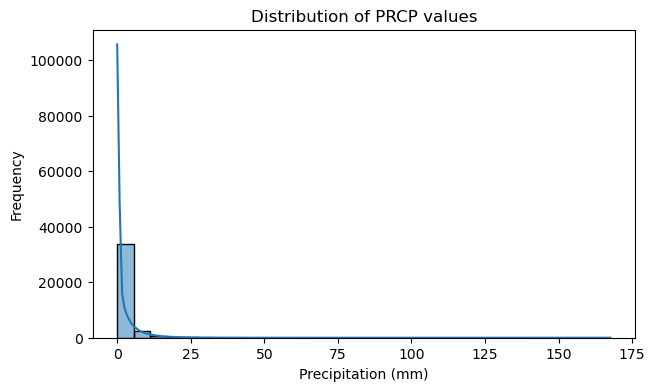

In [6]:
plt.figure(figsize=(7, 4))
sns.histplot(data["PRCP"], kde=True, bins=30)
plt.title("Distribution of PRCP values")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

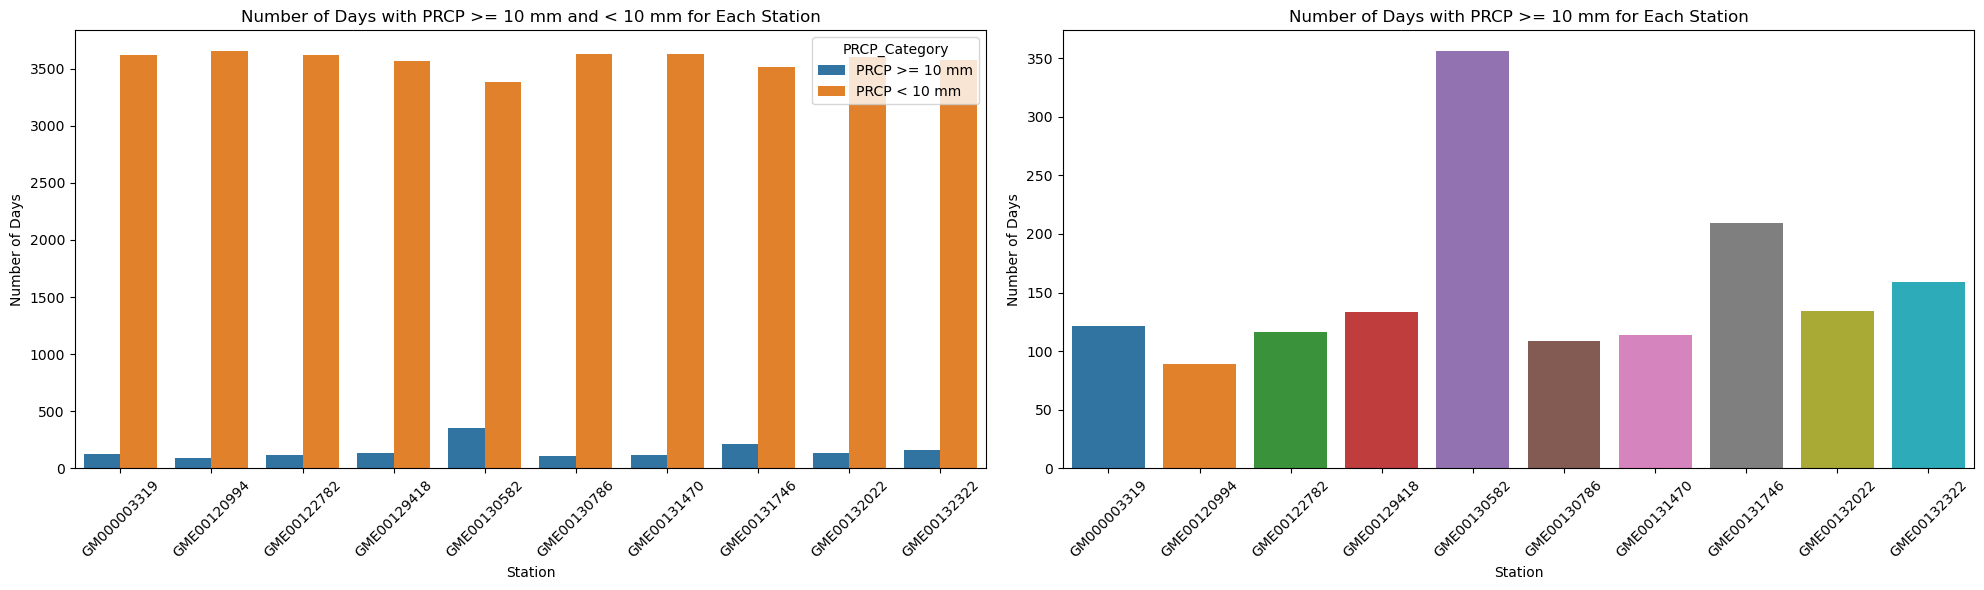

In [7]:
# Create the counts for PRCP >= 10 mm and PRCP < 10 mm for each station
station_prcp_counts_gt_10 = data[data["PRCP"] >= 10].groupby("STATION").size()
station_prcp_counts_le_10 = data[data["PRCP"] < 10].groupby("STATION").size()

station_prcp_counts = (
    pd.DataFrame(
        {
            "PRCP >= 10 mm": station_prcp_counts_gt_10,
            "PRCP < 10 mm": station_prcp_counts_le_10,
        }
    )
    .fillna(0)
    .reset_index()
)

station_prcp_counts_melted = station_prcp_counts.melt(
    id_vars="STATION", var_name="PRCP_Category", value_name="Days"
)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(
    x="STATION",
    y="Days",
    hue="PRCP_Category",
    data=station_prcp_counts_melted,
    ax=axes[0],
)
axes[0].set_title("Number of Days with PRCP >= 10 mm and < 10 mm for Each Station")
axes[0].set_xlabel("Station")
axes[0].set_ylabel("Number of Days")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(x="STATION", y="PRCP >= 10 mm", data=station_prcp_counts, ax=axes[1])
axes[1].set_title("Number of Days with PRCP >= 10 mm for Each Station")
axes[1].set_xlabel("Station")
axes[1].set_ylabel("Number of Days")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

The classes are quite imbalanced

## Checking for seasonal patterns in precipitation

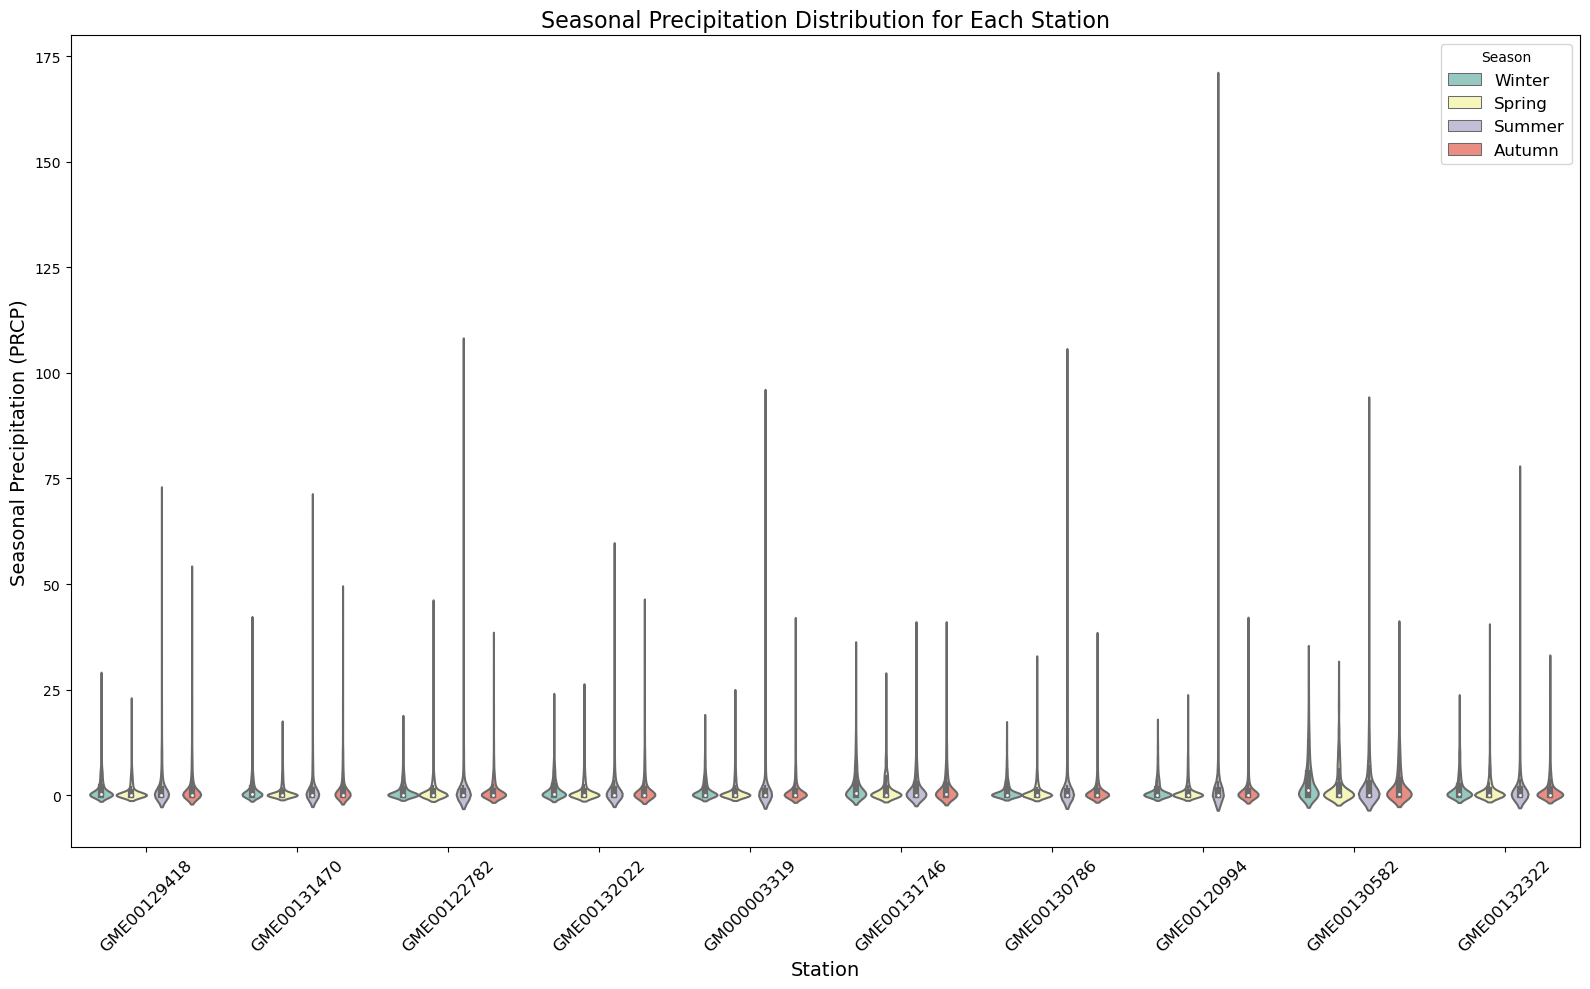

In [8]:
def get_season(date):
    if date.month in [12, 1, 2]:
        return "Winter"
    elif date.month in [3, 4, 5]:
        return "Spring"
    elif date.month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"


data["SEASON"] = data["DATE"].apply(get_season)

plt.figure(figsize=(16, 10))
ax = sns.violinplot(x="STATION", y="PRCP", hue="SEASON", data=data, palette="Set3")
plt.xlabel("Station", fontsize=14)
plt.ylabel("Seasonal Precipitation (PRCP)", fontsize=14)
plt.title("Seasonal Precipitation Distribution for Each Station", fontsize=16)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)

plt.legend(title="Season", fontsize=12)
plt.tight_layout()
plt.show()

## Checking the correlation precipitation with other variables

It seems precipitation is slightly positively influenced by temperature

/tmp/ipykernel_839479/432671750.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


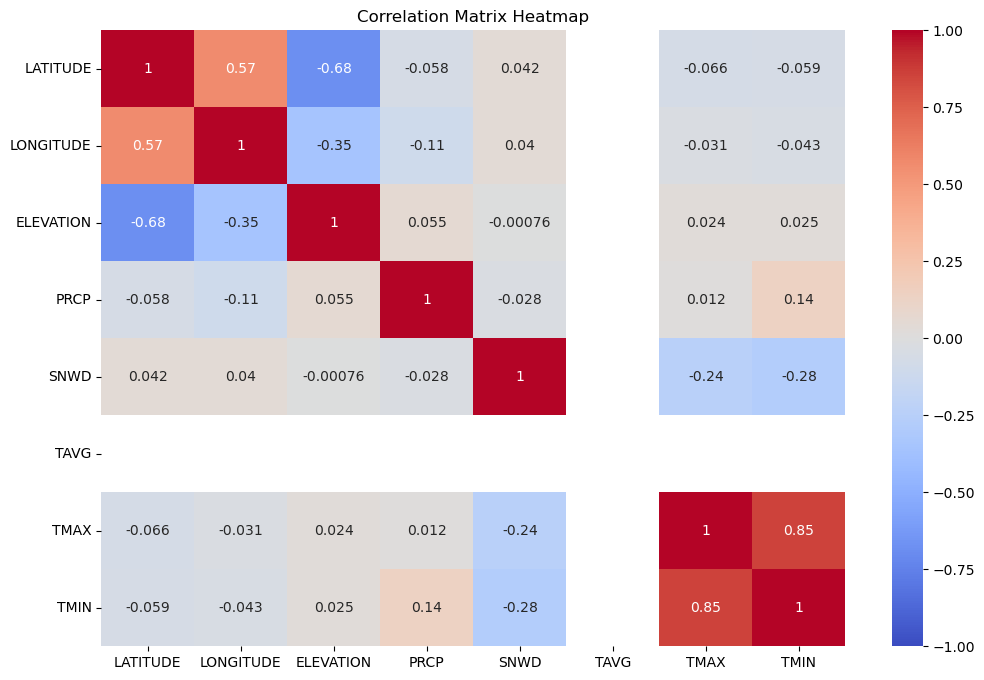

In [9]:
# 5. Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Checking the infleunce of previous 1 to 30 days precipitation infleunce on next day precipitation

It looks that in all stations precipiatation at timestamp t is influence by precipitation by upto t-3

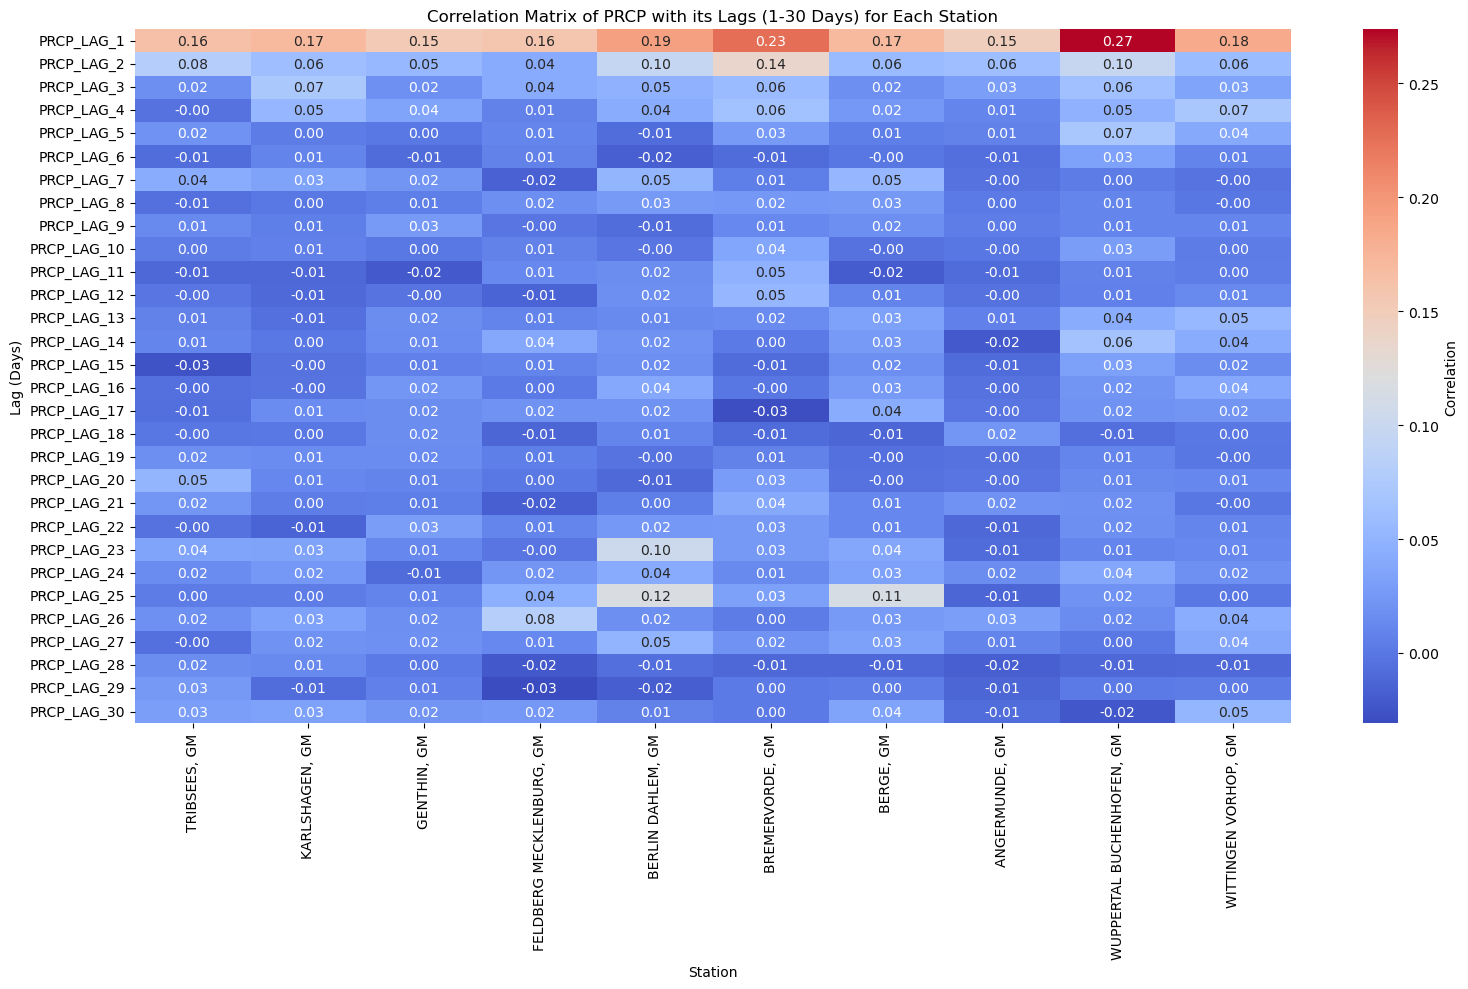

In [10]:
columns_to_drop = ["TAVG", "SNWD"]
data = data.drop(columns=columns_to_drop)


def create_lag_features(df, station_col, prcp_col, max_lag=30):
    lag_df = df.copy()
    for lag in range(1, max_lag + 1):
        lag_df[f"{prcp_col}_LAG_{lag}"] = lag_df.groupby(station_col)[prcp_col].shift(
            lag
        )
    return lag_df


data_with_lags = create_lag_features(data, "NAME", "PRCP")

# Drop rows with NaN values (first few rows will have NaN due to lagging)
data_with_lags = data_with_lags.dropna()

# Calculate correlation of PRCP with its lags for each station
correlations = {}

stations = data_with_lags["NAME"].unique()
for station in stations:
    station_data = data_with_lags[data_with_lags["NAME"] == station]
    if not station_data.empty:
        corr = (
            station_data[[f"PRCP_LAG_{lag}" for lag in range(1, 31)] + ["PRCP"]]
            .corr()["PRCP"]
            .drop("PRCP")
        )
        correlations[station] = corr

correlation_df = pd.DataFrame(correlations)

correlation_df = correlation_df.dropna(axis=1, how="all")

plt.figure(figsize=(16, 10))
sns.heatmap(
    correlation_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"label": "Correlation"},
)
plt.title("Correlation Matrix of PRCP with its Lags (1-30 Days) for Each Station")
plt.xlabel("Station")
plt.ylabel("Lag (Days)")
plt.tight_layout()
plt.show()

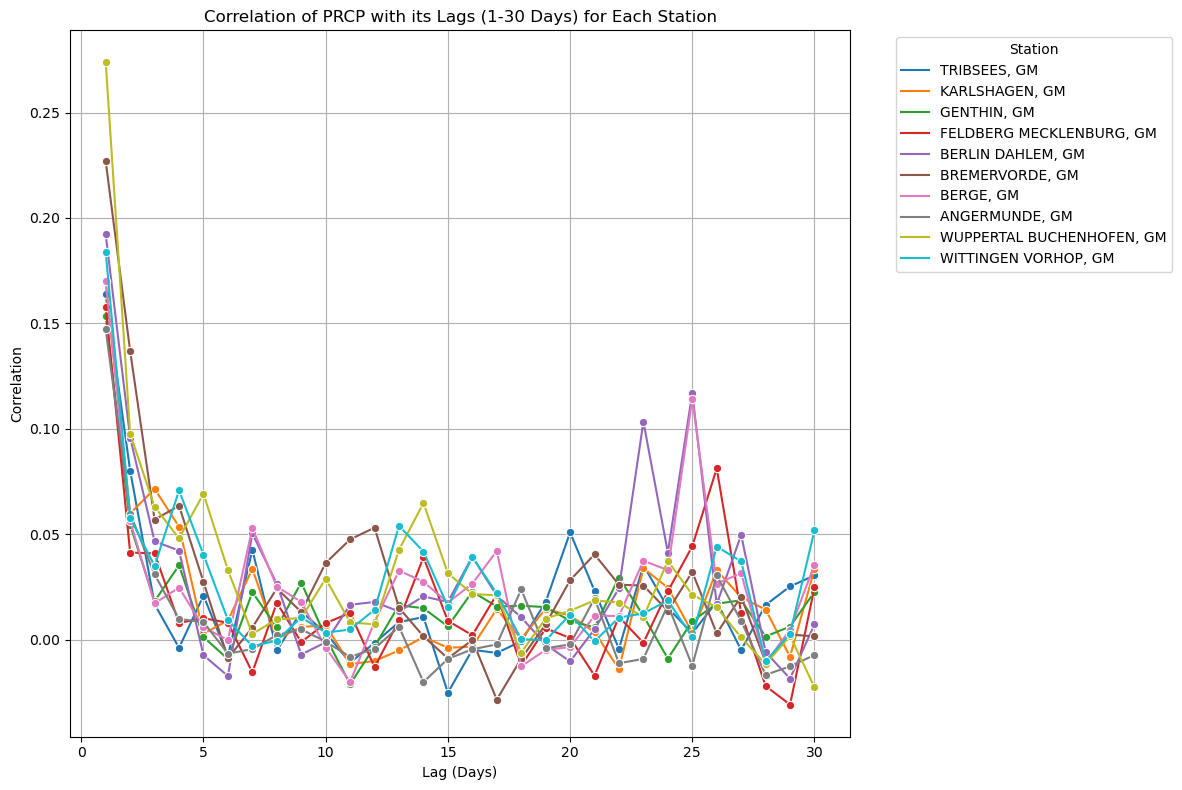

In [11]:
correlation_df = correlation_df.reset_index().melt(
    id_vars="index", var_name="Station", value_name="Correlation"
)
correlation_df.rename(columns={"index": "Lag"}, inplace=True)
correlation_df["Lag"] = correlation_df["Lag"].str.extract("(\d+)").astype(int)

plt.figure(figsize=(12, 8))
sns.lineplot(data=correlation_df, x="Lag", y="Correlation", hue="Station", marker="o")
plt.title("Correlation of PRCP with its Lags (1-30 Days) for Each Station")
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation")
plt.legend(title="Station", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

The correlation of lags with precipitation seems to decrease as we go further back.

In [12]:
data.head()
data2 = data.copy()
data2.set_index('DATE', inplace=True)

## Stationarity test

In [13]:
from statsmodels.tsa.stattools import adfuller

precipitation_data = data2[['STATION', 'PRCP']].sort_index()

adf_results = {}
stations = precipitation_data['STATION'].unique()

for station in stations:
    station_data = precipitation_data[precipitation_data['STATION'] == station]['PRCP'].dropna()
    adf_result = adfuller(station_data)
    adf_results[station] = {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Critical Values': adf_result[4]
    }

In [14]:
adf_results_df = pd.DataFrame(adf_results).T
adf_results_df

,ADF Statistic,p-value,Critical Values
GME00129418,-37.206473,0.0,"{'1%': -3.432117649946455, '5%': -2.8623210498..."
GME00122782,-38.713919,0.0,"{'1%': -3.4321006143182444, '5%': -2.862313524..."
GME00132022,-51.558806,0.0,"{'1%': -3.4321006143182444, '5%': -2.862313524..."
GME00132322,-26.416107,0.0,"{'1%': -3.432101552123037, '5%': -2.8623139390..."
GM000003319,-9.128189,0.0,"{'1%': -3.4321119346833497, '5%': -2.862318525..."
GME00130786,-9.514445,0.0,"{'1%': -3.432110511637569, '5%': -2.8623178966..."
GME00130582,-22.849966,0.0,"{'1%': -3.432101552123037, '5%': -2.8623139390..."
GME00120994,-38.394115,0.0,"{'1%': -3.43209920949247, '5%': -2.86231290420..."
GME00131746,-25.795994,0.0,"{'1%': -3.432109564216738, '5%': -2.8623174781..."
GME00131470,-26.458639,0.0,"{'1%': -3.4321001457923326, '5%': -2.862313317..."


ADF Statistic is less than the critical value (more negative), and the p-value is less than the chosen significance level (e.g., 0.05), the time series is considered stationary

## Time series decomposition

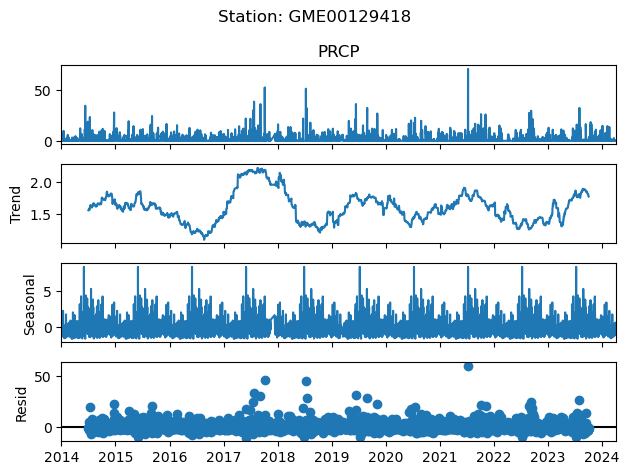

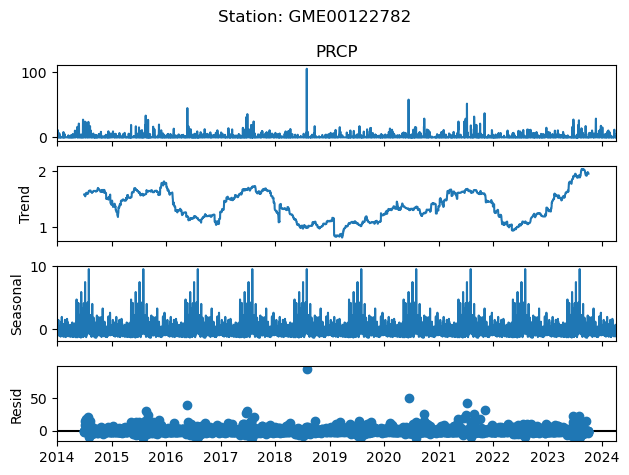

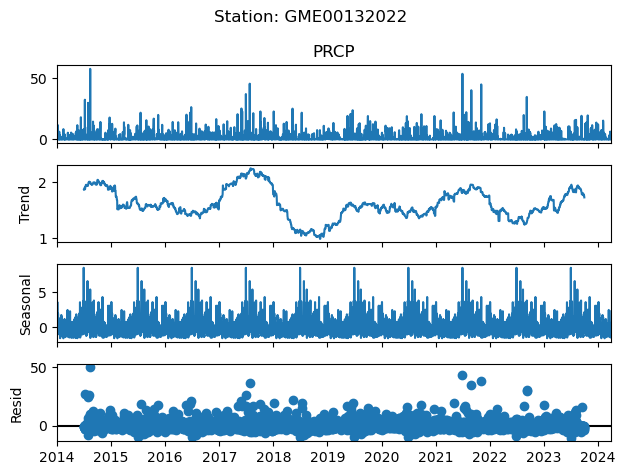

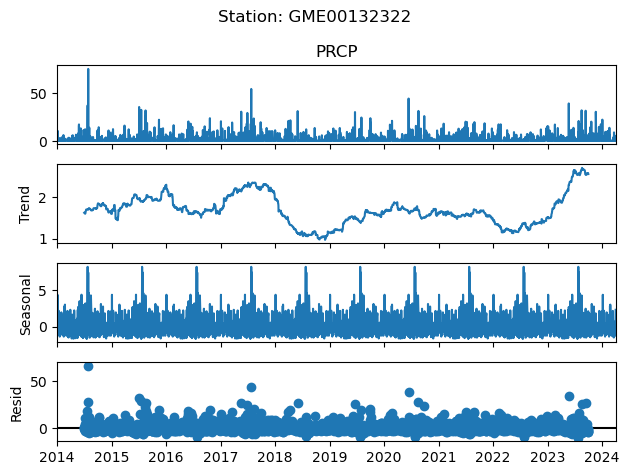

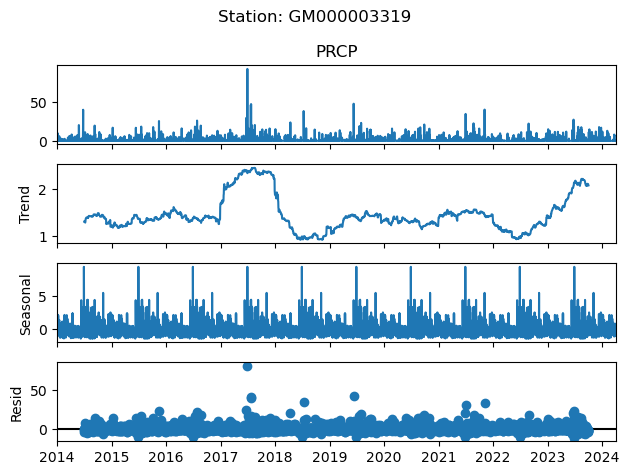

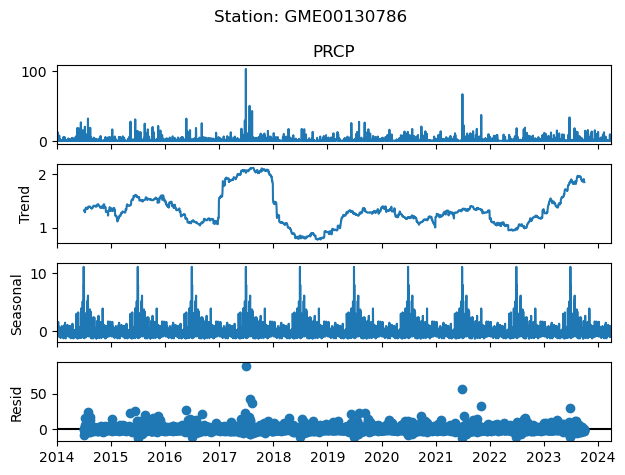

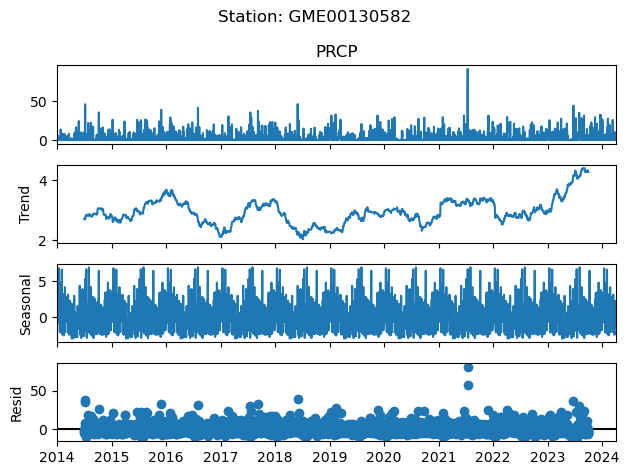

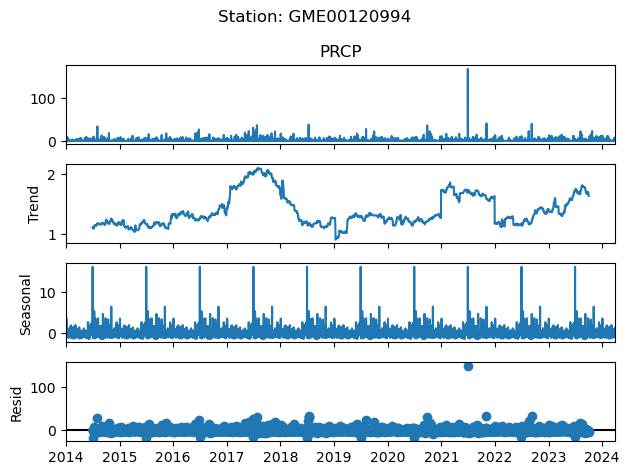

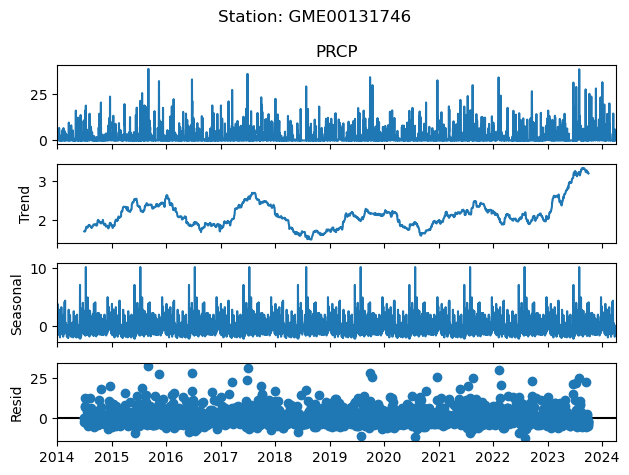

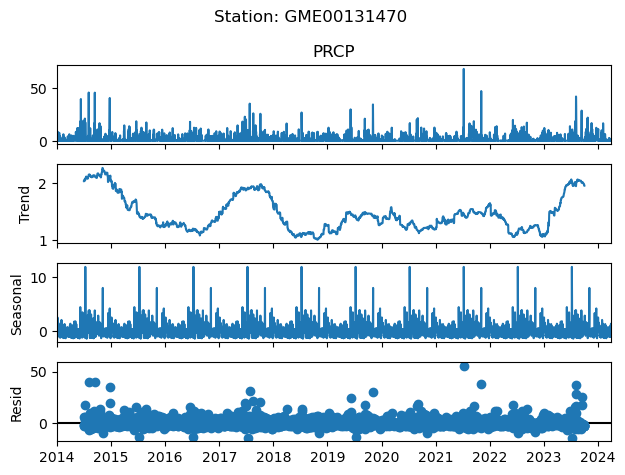

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

stations_to_decompose = precipitation_data['STATION'].unique()

for i, station in enumerate(stations_to_decompose[:10]):
    station_data = precipitation_data[precipitation_data['STATION'] == station]['PRCP'].dropna()
    decomposition = seasonal_decompose(station_data, model='additive', period=365)
    
    result = decomposition.plot()
    result.suptitle(f'Station: {station}')
    plt.tight_layout()
    plt.show()

- Seasonality: Most stations show strong seasonal patterns, with similar periods of high and low precipitation.
- Trends: While some stations show decreasing trends, others show stable or slightly increasing trends, which can be due to localized variations in precipitation patterns.

## Autocorrelation

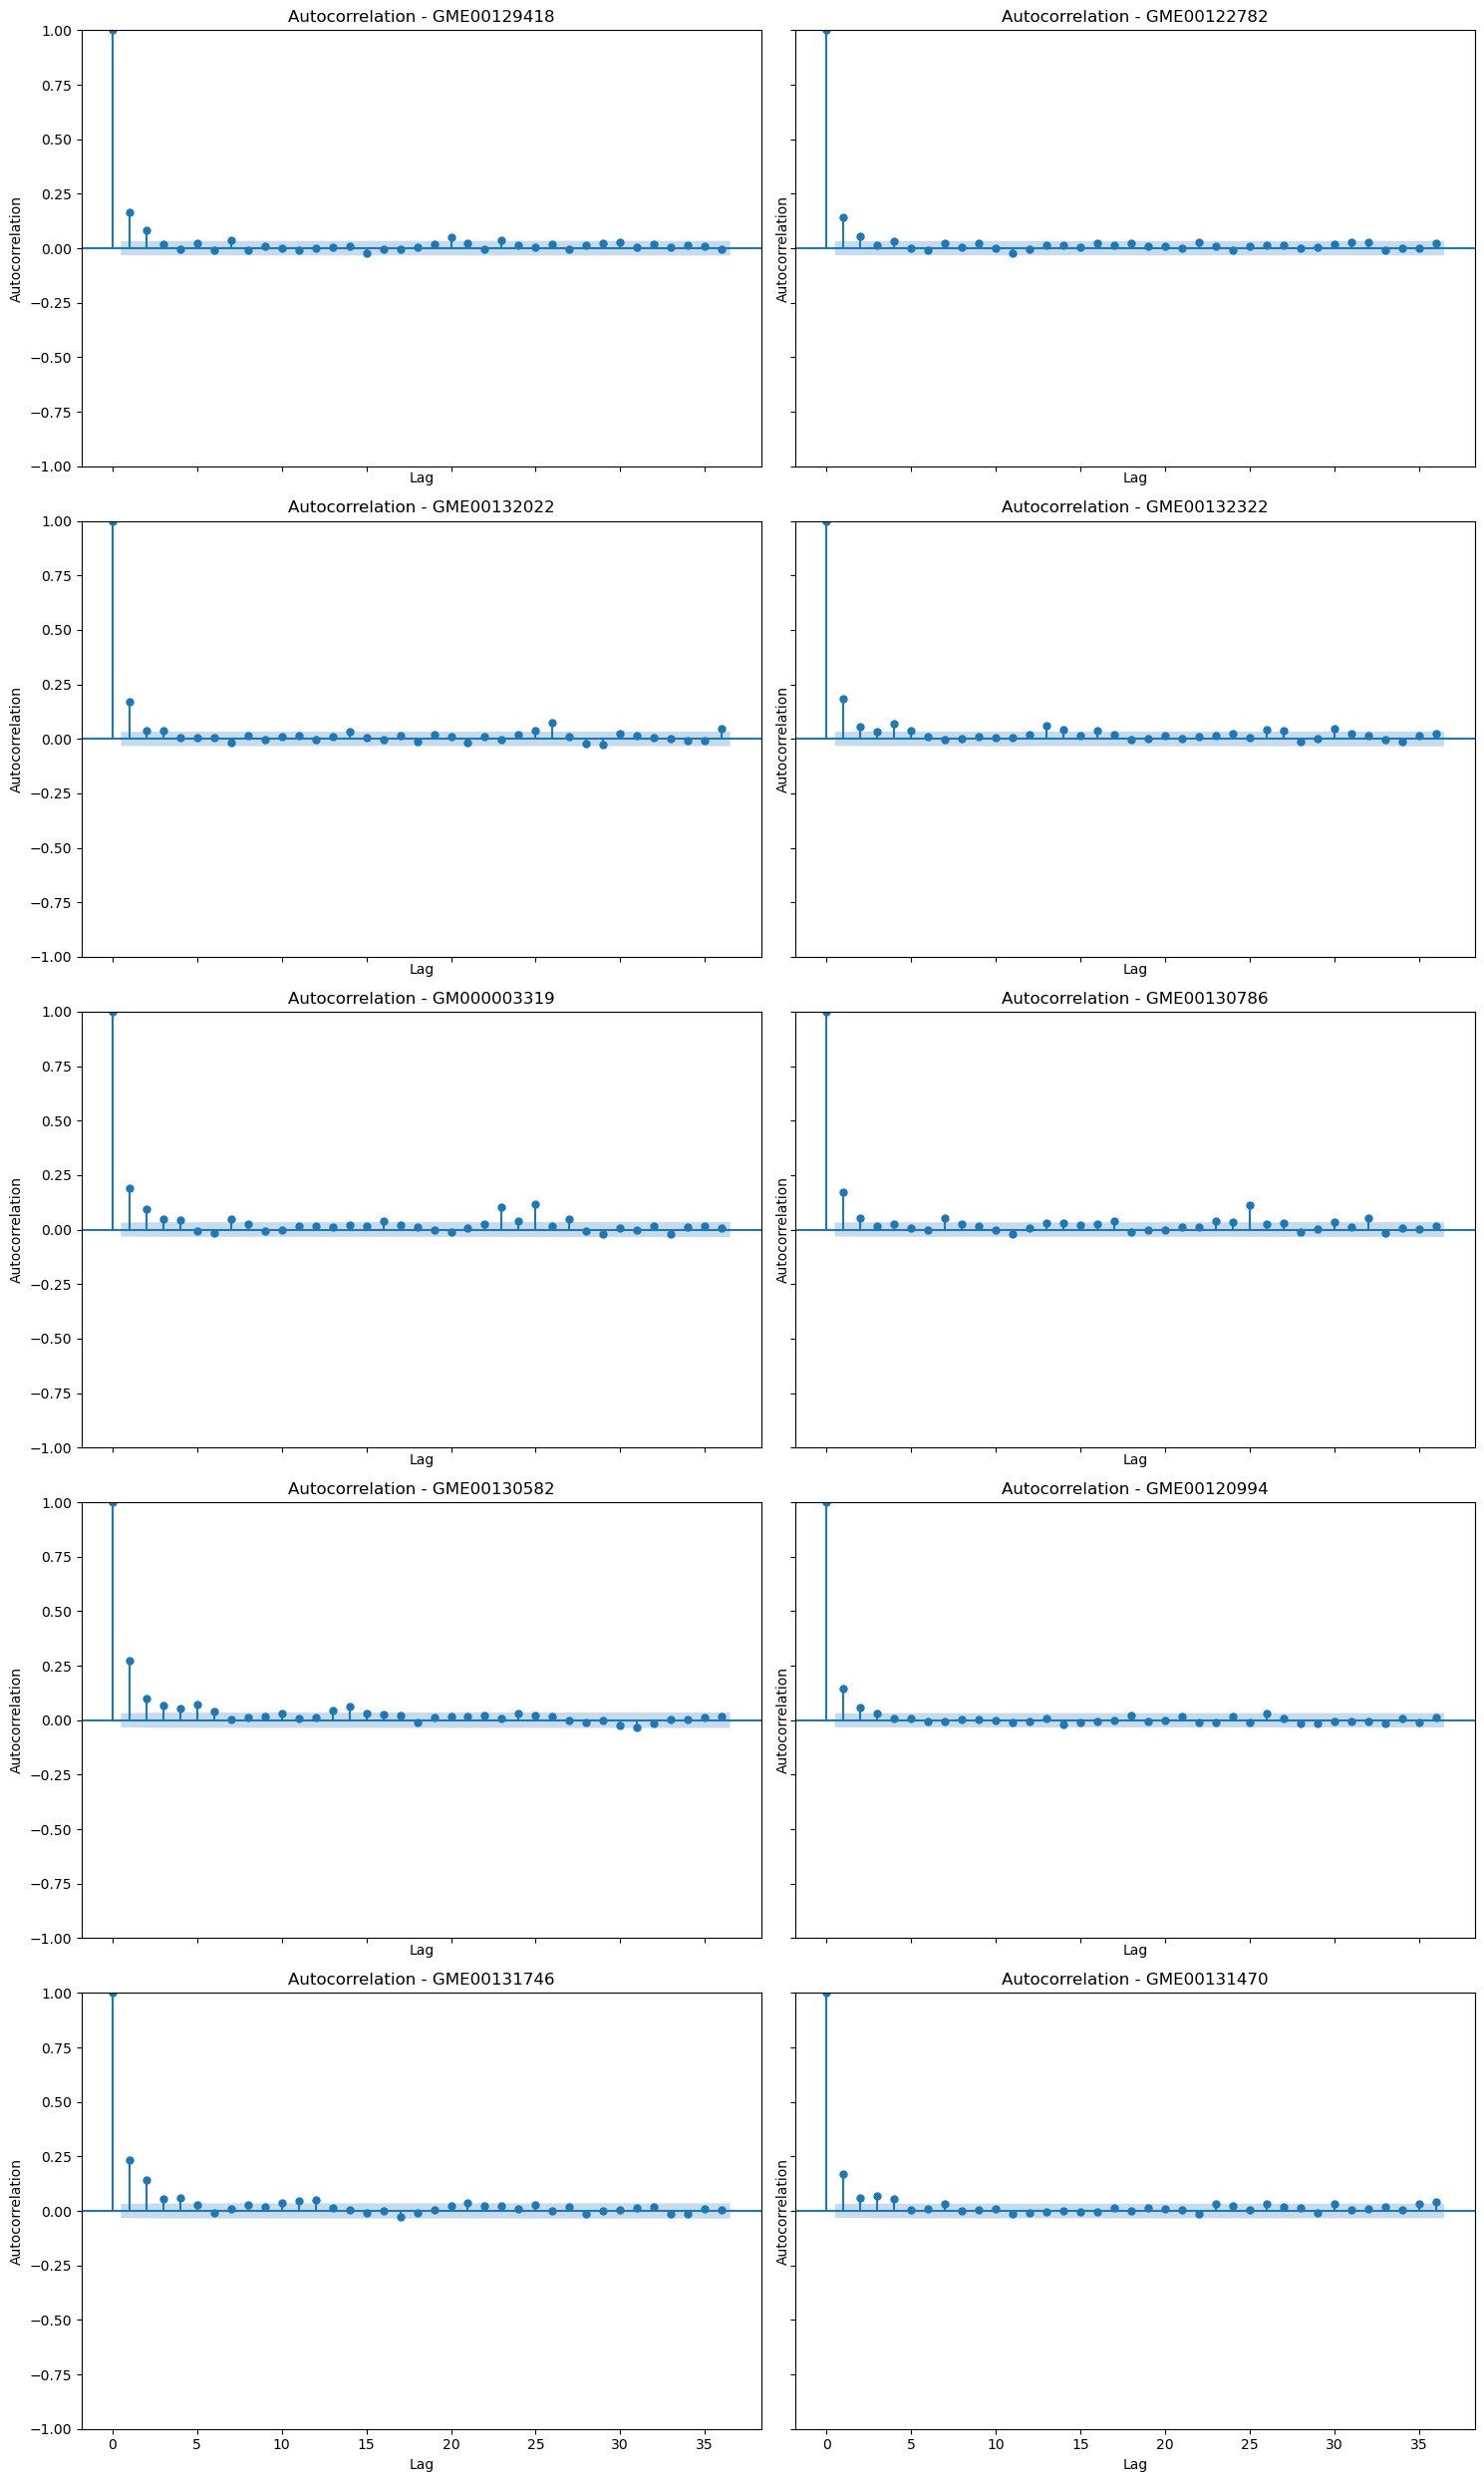

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(5, 2, figsize=(15, 25), sharex=True, sharey=True)

for i, station in enumerate(stations_to_decompose[:10]):
    station_data = precipitation_data[precipitation_data['STATION'] == station]['PRCP'].dropna()
    
    row = i // 2
    col = i % 2
    
    plot_acf(station_data, ax=axes[row, col], title=f'Autocorrelation - {station}')
    axes[row, col].set_xlabel('Lag')
    axes[row, col].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

Autocorrelation measures how a time series is correlated with a lagged version of itself. In all station a relatively high autocorrelation at lag 1 is seen. The data points are highly correlated with the values from previos day.

----